In [1]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score,f1_score
from matplotlib import rcParams

In [2]:
# use this do download stopwords if you haven't done this before
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# loading in dataframe, using special encoder parameter to save it correctly
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [4]:
# renaming the columns
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

In [5]:
df['tweet'] = df['tweet'].str.lower()

In [6]:
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

In [7]:
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

C:\Users\User\anaconda3_1\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\anaconda3_1\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [9]:
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-9-3c2e651705a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [10]:
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [11]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [12]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [13]:
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-13-7638a198be87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'], df_binary['emotion_label'], train_size=.9)

In [15]:
og_stopwords = stopwords.words('english')

## Baseline Model

In [16]:
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [17]:
baseline_model = MultinomialNB()

In [18]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.847942892686828

In [19]:
# finding training score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.860823122840088


In [20]:
#Evaluating recall
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.12103174603174603

## Iteration 1: Decision Tree

In [21]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [22]:
dt = DecisionTreeClassifier()

In [23]:
# Evaluate the classifier on basekube_vectorized and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8400837257980115

In [24]:
# finding training score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

0.9996858309770656


In [25]:
#Evaluating recall
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.12103174603174603

## Iteration 2: Random Forest

In [26]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [27]:
rf = RandomForestClassifier()

In [28]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8696212592439008

In [29]:
# finding training score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9996858309770656


In [30]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.998015873015873

## Iteration 3: Vectorizer 

In [31]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)

# five is the best input for our min_df parameter
# (1,2) is the best input for our ngram_range parameter

In [32]:
# Evaluate the random forest
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8715065706979453

In [33]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

0.9996858309770656


In [34]:
#Evaluating recall
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

0.998015873015873

In [35]:
# looking at the shape of our tfidf sparse matrix
# pd.DataFrame.sparse.from_spmatrix(vectorized_3, columns=tfidf_3.get_feature_names()).shape

## Iteration 4 - Random Forest

In [36]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [37]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

In [38]:
# GS_rf1.fit(vectorized_4,y_train)

In [39]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [40]:
# GS_rf1.best_score_

0.8695299008634473

In [41]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [42]:
#GS_rf2.fit(vectorized_4,y_train)

In [43]:
#GS_rf2.best_params_

In [44]:
#GS_rf2.best_score_

In [45]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [46]:
#GS_rf3.fit(vectorized_4,y_train)

In [47]:
#GS_rf3.best_params_

In [48]:
#GS_rf3.best_score_

In [49]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [50]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8711911179566165

In [51]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9990574929311969


In [52]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.9940476190476191

## Incorporating Additional Stopwords

In [53]:
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [54]:
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [55]:
pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

In [56]:
pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

In [57]:
pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [58]:
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [59]:
neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

In [60]:
neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

In [61]:
neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'iphone',
 'ipad',
 'quot',
 'google',
 'apple',
 'rt',
 'rt mention',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.8737019045644383

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9940307885642475


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.9722222222222222

### Recreate Positive and Negative Lists

#### Positive Words

In [71]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [72]:
# pos_words_sorted_2

#### Negative Words

In [73]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [74]:
# neg_words_sorted_2

## Wordcloud

In [75]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: six>=1.5 in c:\users\user\anaconda3_1\envs\learn-env\lib\site-packages (from python-dateutil>=2.1->matplotlib->wordcloud) (1.15.0)



In [76]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [77]:
custom_mask = np.array(Image.open("twitter_bw.png"))
pos_cloud = WordCloud(mask=custom_mask, background_color="white", colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

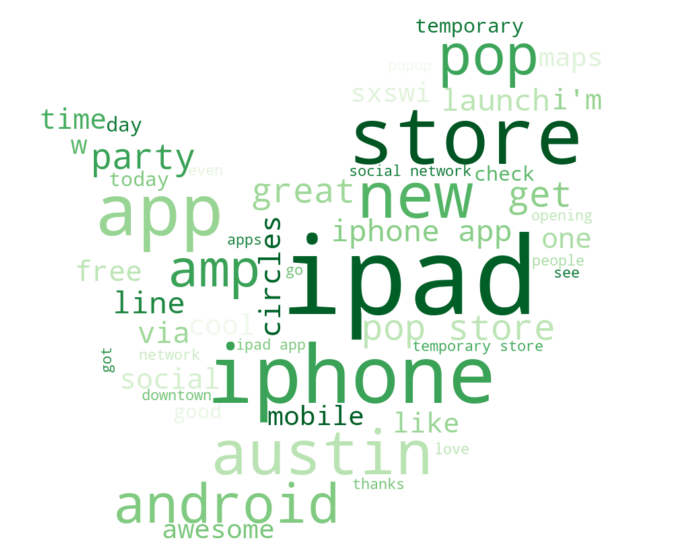

In [78]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Wordcloud

In [79]:
custom_mask = np.array(Image.open("twitter_bw.png"))
neg_cloud = WordCloud(mask=custom_mask, colormap='Reds', background_color="white", max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

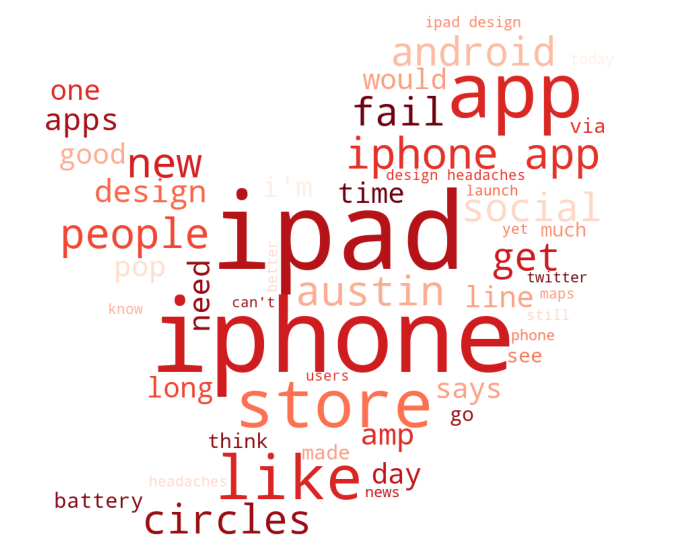

In [80]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show()

## Iteration 6 - Random Forest max_depth adjustments

In [81]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[275,
 266,
 263,
 222,
 261,
 266,
 258,
 215,
 312,
 218,
 264,
 272,
 272,
 248,
 254,
 264,
 252,
 239,
 264,
 240,
 229,
 151,
 266,
 243,
 235,
 227,
 272,
 217,
 238,
 245,
 246,
 234,
 274,
 160,
 234,
 293,
 229,
 247,
 249,
 242,
 262,
 244,
 207,
 230,
 250,
 267,
 237,
 248,
 245,
 218,
 194,
 267,
 234,
 252,
 179,
 259,
 263,
 275,
 229,
 253,
 251,
 273,
 282,
 263,
 259,
 257,
 261,
 261,
 282,
 255,
 273,
 236,
 265,
 266,
 241,
 260,
 215,
 264,
 259,
 281,
 134,
 282,
 257,
 238,
 260,
 253,
 273,
 307,
 155,
 266,
 240,
 246,
 300,
 241,
 150,
 244,
 295,
 262,
 237,
 256,
 314,
 240,
 240,
 266,
 236,
 257,
 292,
 155,
 279,
 254,
 180,
 233,
 234,
 219,
 272,
 247,
 236,
 164,
 268,
 233,
 183,
 283,
 252,
 164,
 218,
 263,
 230,
 147,
 265,
 213,
 250,
 252,
 219,
 241,
 252,
 283,
 265,
 182,
 297,
 273,
 257,
 267,
 236,
 274,
 246,
 215,
 261,
 285,
 216,
 151,
 165,
 234,
 266,
 297,
 252,
 247,
 268,
 238,
 238,
 299,
 231,
 152,
 236,
 244,
 256,
 241,
 217

In [82]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [83]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [84]:
#GS_rf4.fit(vectorized_6, y_train)

In [85]:
#GS_rf4.best_params_

In [86]:
#GS_rf4.best_score_

### Run Final Model on Test Set

In [87]:
test_vec = tfidf_5.transform(X_test)

In [88]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.3230769230769231

In [89]:
accuracy_score(y_test, test_pred)

0.8531073446327684

In [90]:
precision_score(y_test, test_pred)

0.7241379310344828

In [91]:
rf5.score(test_vec, y_test)

0.8531073446327684

## Model Visualization

In [92]:
vectorized_5 = tfidf_5.fit_transform(X_train)

In [93]:
final_s_matrix= pd.DataFrame.sparse.from_spmatrix(vectorized_5, columns=tfidf_5.get_feature_names())

In [94]:
final_10_words = final_s_matrix.mean(axis=0).sort_values(ascending=False).head(10)

In [95]:
final_10_df = final_10_words.to_frame()

In [96]:
final_10_df = final_10_df.reset_index()

In [97]:
final_10_df.rename(columns={"index": "word", 0: "tfidf_score"},inplace=True)

In [98]:
final_10_df

,word,tfidf_score
0,ipad,0.055069
1,iphone,0.037236
2,store,0.031327
3,app,0.026191
4,new,0.020654
5,austin,0.019185
6,android,0.016146
7,pop,0.016115
8,amp,0.014779
9,get,0.013090


findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans.


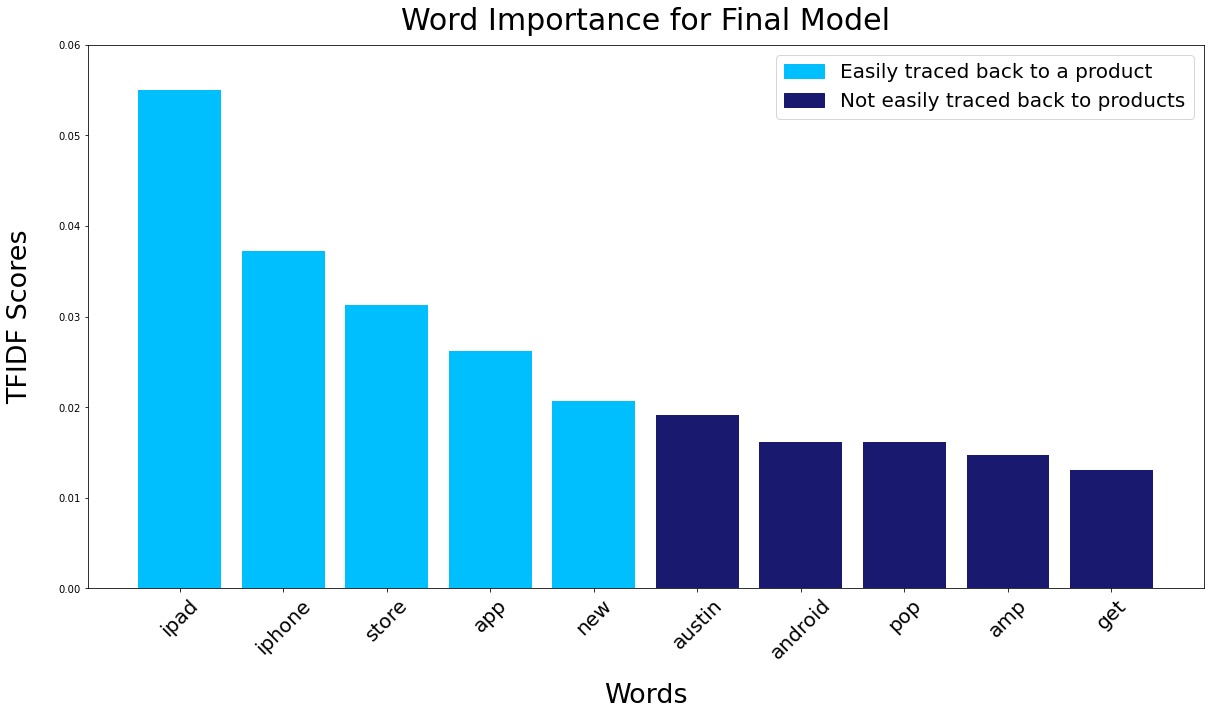

In [99]:
# Visualize word Importance

# Create variables for chart
important_words_x = final_10_df['word']
words = final_10_df['tfidf_score']

c = ['deepskyblue', 'deepskyblue','deepskyblue', 'deepskyblue',
     'deepskyblue', 'midnightblue', 'midnightblue', 'midnightblue', 'midnightblue',
     'midnightblue']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))
bars = ax.bar(x = important_words_x, height = words,color= c)
ax.set_xlabel('Words', fontsize=27, labelpad=20) 
ax.set_ylabel('TFIDF Scores', fontsize=27, labelpad=25)
ax.set_title('Word Importance for Final Model', fontsize=30, pad=15)
ax.set_ylim(0, 0.060, 0.005)
ax.set_xticks(important_words_x)
ax.set_xticklabels(important_words_x, fontsize=20, rotation=45)
colors = {'Easily traced back to a product':'deepskyblue', 'Not easily traced back to products':'midnightblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#plt.legend(handles, labels)
ax.legend(handles, labels,loc=0,prop={'size': 20})
plt.savefig('./Results/Final_Model_Top_10_Words.jpg', bbox_inches='tight');



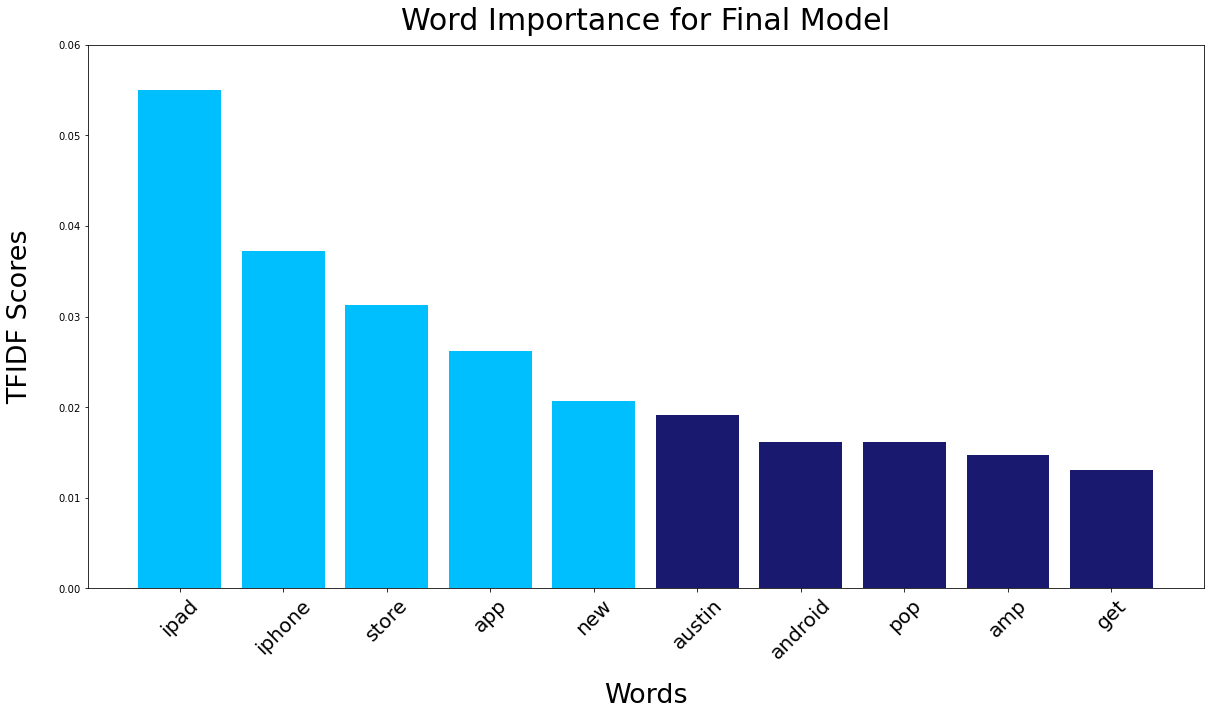

In [100]:
# Visualize word Importance

# Create variables for chart
important_words_x = final_10_df['word']
words = final_10_df['tfidf_score']

c = ['deepskyblue', 'deepskyblue','deepskyblue', 'deepskyblue',
     'deepskyblue', 'midnightblue', 'midnightblue', 'midnightblue', 'midnightblue',
     'midnightblue']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))
bars = ax.bar(x = important_words_x, height = words,color= c)
ax.set_xlabel('Words', fontsize=27, labelpad=20) 
ax.set_ylabel('TFIDF Scores', fontsize=27, labelpad=25)
ax.set_title('Word Importance for Final Model', fontsize=30, pad=15)
ax.set_ylim(0, 0.060, 0.005)
ax.set_xticks(important_words_x)
ax.set_xticklabels(important_words_x, fontsize=20, rotation=45)
#colors = {'Easily traced back to a product':'deepskyblue', 'Not easily traced back to products':'midnightblue'}         
#labels = list(colors.keys())
#handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#plt.legend(handles, labels)
#ax.legend(handles, labels,loc=0,prop={'size': 20})
plt.savefig('./Results/Final_Model_Top_10_Words_nolabel.jpg', bbox_inches='tight');

